In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder

# Local imports
from src.collaborative_filtering import *
from src.database import * # <--- database approach

# Collaborative Filtering

### We read x amount of playlist slices into memory
Each contains 1000 playlists. For example, 20 slices will take about 5GB of memory

In [2]:
folder = "data/playlist_data/"
co_occurences = update_co_occurrences_from_folder(folder, slice_limit=10)

Processing slice 1/10: mpd.slice.0-999.json
Processing slice 2/10: mpd.slice.1000-1999.json
Processing slice 3/10: mpd.slice.10000-10999.json
Processing slice 4/10: mpd.slice.100000-100999.json
Processing slice 5/10: mpd.slice.101000-101999.json
Processing slice 6/10: mpd.slice.102000-102999.json
Processing slice 7/10: mpd.slice.103000-103999.json
Processing slice 8/10: mpd.slice.104000-104999.json
Processing slice 9/10: mpd.slice.105000-105999.json
Processing slice 10/10: mpd.slice.106000-106999.json


### We create a playlists for testing recommendations

In [3]:
# "90s Playlist"

playlist_1 = [
    ("Smash Mouth" ,"All Star"),
    ("Rick Astley", "Never Gonna Give You Up"),
    ("The Proclaimers", "I'm Gonna Be (500 Miles)"),
    ("Backstreet Boys", "I Want It That Way"),
    ("The Killers", "Mr. Brightside"),
]


In [4]:
get_recommendations(playlist_1, co_occurences, top_n=10)

Journey - Don't Stop Believin' - 0.13188586446897396
Dexys Midnight Runners - Come On Eileen - 0.11558917143086936
Queen - Bohemian Rhapsody - Remastered 2011 - 0.09575053075308512
Oasis - Wonderwall - Remastered - 0.08676226378313022
blink-182 - All The Small Things - 0.08304995838777059
Neil Diamond - Sweet Caroline - 0.08189131940180075
a-ha - Take On Me - 0.0813341794072309
*NSYNC - Bye Bye Bye - 0.08070006297914985
R. Kelly - Ignition - Remix - 0.07976270477218977
Lynyrd Skynyrd - Sweet Home Alabama - 0.07903365179784766


In [5]:
#"Pop Playlist"

playlist_2 = [
    ("Drake", "One Dance"),
    ("The Chainsmokers", "Closer"),
    ("Ed Sheeran", "Shape of You"),
    ("Justin Bieber", "Sorry"),
    ("The Weeknd", "Starboy"),
]


In [6]:
get_recommendations(playlist_2, co_occurences, top_n=10)

Major Lazer - Cold Water (feat. Justin Bieber & MØ) - 0.1296711580904797
The Chainsmokers - Don't Let Me Down - 0.11929367921532696
Mike Posner - I Took A Pill In Ibiza - Seeb Remix - 0.09971091336986375
DJ Snake - Let Me Love You - 0.09336027492751028
DRAM - Broccoli (feat. Lil Yachty) - 0.09267479578748074
DJ Khaled - I'm the One - 0.08906682405001495
Desiigner - Panda - 0.08653596180051237
Sia - Cheap Thrills - 0.08601534699850658
Calvin Harris - This Is What You Came For - 0.08439987861697273
Aminé - Caroline - 0.08439515679798462


___
# Content based filtering

In [7]:
song_data = pd.read_csv('data/song_data.csv')
# Remove key, mode, time_signature, and duration_ms
song_data = song_data.drop(['key', 'mode', 'time_signature', 'duration_ms'], axis=1)

## Implement KNN

#### Feature scaling

In [8]:
# Scale numerical features
numerical_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
X = song_data[numerical_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Genre encoding
categorical_features = ['genre']#, 'artist_name', 'year']
genres = song_data[categorical_features]
encoder = OneHotEncoder()
genres_encoded = encoder.fit_transform(genres).toarray()

#### Combine genres and numerical features and fit

In [10]:
genre_weight = 20 # The higher the weight, the more important the genre is in the recommendation

X_combined = np.concatenate((X_scaled, genres_encoded * genre_weight), axis=1)

knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
knn.fit(X_combined)

NearestNeighbors(metric='euclidean', n_neighbors=10)

## Song Query

In [11]:
# Define song and artist which we want to find similar songs for
song_name = 'Boten Anna - Radio edit'
artist_name = 'Basshunter'

song_name2 = 'Show Me How'
artist_name2 = 'Men I Trust'

# Find the song in the dataset
song_query = song_data[(song_data['track_name'].str.lower() == song_name.lower()) & (song_data['artist_name'].str.lower() == artist_name.lower())]
song_query2 = song_data[(song_data['track_name'].str.lower() == song_name2.lower()) & (song_data['artist_name'].str.lower() == artist_name2.lower())]

[0.0635, 0.464, 0.971, 0.000108, 0.073, -0.05546, 0.26, 0.7787722222222222, 0.265]
[0.674, 0.791, 0.267, 0.534, 0.102, -0.11997, 0.0415, 0.9221666666666667, 0.544]


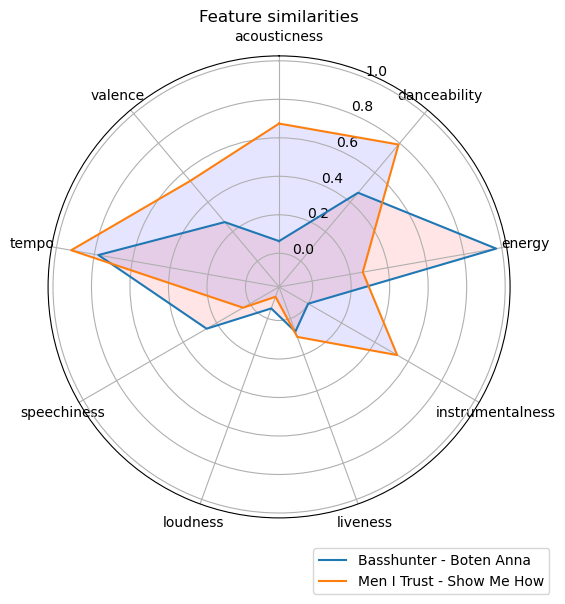

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
categories = numerical_features
N = len(categories)

# Values in a range from 0 to 1 for each category
# The values must be in the same order as the categories
values1 = song_query[numerical_features].values.tolist()[0]
values2 = song_query2[numerical_features].values.tolist()[0]

values1[7] /= 180
values2[7] /= 180
values1[5] /= 100
values2[5] /= 100

print(values1)
print(values2)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  

# Your values lists must also complete the loop by having the first value at the end.
values1 += values1[:1]
values2 += values2[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories)

# Draw one axe per variable + add labels
ax.plot(angles, values1, label='Basshunter - Boten Anna')
ax.fill(angles, values1, 'red', alpha=0.1)

ax.plot(angles, values2, label='Men I Trust - Show Me How')
ax.fill(angles, values2, 'blue', alpha=0.1)

# Add legend and title
plt.legend(bbox_to_anchor=(1.1, -0.05))
plt.title('Feature similarities')

plt.show()

In [13]:
recommendations_idx = []

if not song_query.empty:
    # Scale numerical features of the query
    song_numerical_features = scaler.transform(song_query[numerical_features])
    
    # Encode genre of the query
    song_genre_encoded = encoder.transform(song_query[['genre']]).toarray()
    
    # Combine scaled numerical features and encoded genre for the query
    song_combined_features = np.hstack((song_numerical_features, song_genre_encoded * 20))
    
    # Use KNN to find the nearest neighbors
    distances, indices = knn.kneighbors(song_combined_features)
    
    print('Closest songs are:\n')
    for i in range(1, 6):
        index = indices[0][i]
        recommendations_idx.append(index)
        song_info = song_data.iloc[index][['track_name', 'artist_name']]

        print(f"{song_info['artist_name']} - {song_info['track_name']}")
        
else:
    print("No song found. Check the song and artist names.")

Closest songs are:

Digitalism - Circles
Basshunter - I Can Walk On Water
T.I. - No Matter What
Fergie - Barracuda
Slushii - Sober


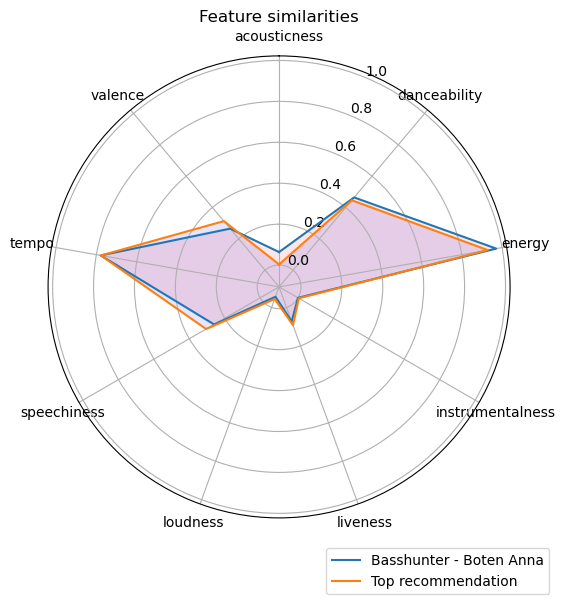

In [14]:
categories = numerical_features
N = len(categories)

# Values in a range from 0 to 1 for each category
values1 = song_query[numerical_features].values.tolist()[0]
values2 = song_data.iloc[recommendations_idx[0]][numerical_features].values.tolist()


#scaling to 0-1
values1[7] /= 180
values2[7] /= 180
values1[5] /= 100
values2[5] /= 100

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  

values1 += values1[:1]
values2 += values2[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories)

ax.plot(angles, values1, label='Basshunter - Boten Anna')
ax.fill(angles, values1, 'red', alpha=0.1)

ax.plot(angles, values2, label='Top recommendation')
ax.fill(angles, values2, 'blue', alpha=0.1)

plt.legend(bbox_to_anchor=(1.1, -0.05))
plt.title('Feature similarities')

plt.show()



In [15]:
playlist_2 = [
    ("Drake", "One Dance"),
    ("The Chainsmokers", "Closer"),
    ("Ed Sheeran", "Shape of You"),
    ("Justin Bieber", "Sorry"),
    ("The Weeknd", "Starboy (feat. Daft Punk)"),
]


playlist_numerical_features = []
playlist_genre_encoded = []
recommendations_idx = []

song_queries = []

for artist_name, song_name in playlist_2:
    song_query = song_data[(song_data['track_name'].str.lower() == song_name.lower()) & (song_data['artist_name'].str.lower() == artist_name.lower())]
    song_queries.append(song_query)
    if not song_query.empty:
        # Scale numerical features of the query
        song_numerical_features = scaler.transform(song_query[numerical_features])
        playlist_numerical_features.append(song_numerical_features)
        
        # Encode genre of the query
        song_genre_encoded = encoder.transform(song_query[['genre']]).toarray()
        playlist_genre_encoded.append(song_genre_encoded)
    else:
        print(f'No song found for {song_name} by {artist_name}. Check the song and artist names.')
        continue

# Aggregate features of the playlist
if playlist_numerical_features and playlist_genre_encoded:

    average_numerical_features = np.mean(np.vstack(playlist_numerical_features), axis=0)
    average_genre_encoded = np.mean(np.vstack(playlist_genre_encoded), axis=0)

    # Determine variance across the playlist for each numerical feature to use as a simple importance metric
    variances = np.var(np.vstack(playlist_numerical_features), axis=0)
    importance_weights = 1 / (variances + 1e-6)  
    normalized_importance_weights = importance_weights / importance_weights.max()

    # Apply weights to the aggregated playlist features
    weighted_playlist_features = average_numerical_features * normalized_importance_weights

    # Apply the same weighting to the full dataset numerical features before fitting KNN
    weighted_numerical_features = X * normalized_importance_weights

    X_scaled_new = scaler.fit_transform(weighted_numerical_features)

    X_combined_new = np.hstack([X_scaled_new, genres_encoded])


    knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
    knn.fit(X_combined_new)

    # Re-combine weighted numerical features with encoded categorical for the full dataset
    playlist_combined_features = np.hstack([weighted_playlist_features, average_genre_encoded])

    distances, indices = knn.kneighbors([playlist_combined_features])
    
    print('Closest songs to the playlist are:\n')
    for i in range(5):
        index = indices[0][i]
        recommendations_idx.append(index)
        song_info = song_data.iloc[index][['track_name', 'artist_name']]

        print(f"{song_info['artist_name']} - {song_info['track_name']}")
else:
    print('The playlist is empty or no songs were found.')


Closest songs to the playlist are:

Jhené Aiko - W.A.Y.S.
Conan Gray - People Watching
Aloe Blacc - Wake Me Up - Acoustic
Lamp - Winter Cafe
Tems - Free Mind


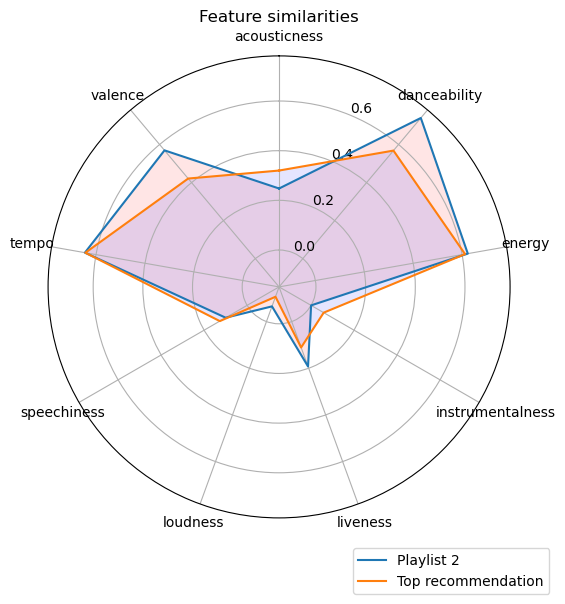

In [16]:

values_total =  song_queries[0][numerical_features].values[0]

for sq in song_queries[1:]:
    values_total += sq[numerical_features].values[0]

values_total /= 5
    

# Values in a range from 0 to 1 for each category
values1 = values_total.tolist()
values2 = song_data.iloc[recommendations_idx[0]][numerical_features].values.tolist()


values1[7] /= 180
values2[7] /= 180
values1[5] /= 80
values2[5] /= 80

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  

values1 += values1[:1]
values2 += values2[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories)

ax.plot(angles, values1, label='Playlist 2')
ax.fill(angles, values1, 'red', alpha=0.1)

ax.plot(angles, values2, label='Top recommendation')
ax.fill(angles, values2, 'blue', alpha=0.1)

plt.legend(bbox_to_anchor=(1.1, -0.05))
plt.title('Feature similarities')

plt.show()

